# Application: Stellar Structure

During most of their lifetimes, stars are in hydrostatic and thermal equilibrium, and the structure of a star is well-described by the equations of stellar structure:

\begin{align*}
\frac{dP}{dr} &= -\rho \frac{Gm}{r^2} \\
\frac{dm}{dr} &= 4\pi r^2 \rho \\
\frac{dT}{dr} &= -\frac{3}{4ac} \frac{\kappa\rho}{T^3} \frac{F}{4\pi r^2} \\
\frac{dF}{dr} &= 4\pi r^2 \rho q
\end{align*}

with an equation of state, opacity, and energy generation rate of the form:

\begin{align*}
P &= \frac{\rho k T}{\mu_I m_u} + P_e + \frac{1}{3} a T^4 \\
\kappa &= \kappa_0 \rho^a T^b \\
q &= q_0 \rho^m T^n
\end{align*}

Here, $P$ is the pressure, $m$ is the mass enclosed inside a radius $r$, $T$ is the temperature, where we assume radiative equilibrium with $F$ describing an energy flux through a shell of radius $r$ and $\kappa$ the opacity of the material.  Finally $q$ is the energy generation rate from nuclear processes.  

This is a 2-point boundary value problem, with boundary conditions:

\begin{align*}
r(m=0) &= 0 \\
F(m=0) &= 0
\end{align*}

at the center and

\begin{align*}
P(m=M_\star) &= 0 \\
T(m=M_\star) &= T_\mathrm{eff} 
\end{align*}

at the surface.

We'll look at a simplified model here.

## Polytropes

If we consider just the first 2 equations, hydrostatic equilibrium and mass continuity, we can close the system of equations if we have an equation of state of the form $P = P(\rho)$.  This eliminates the need for the energy equations, simplifying the model and its solution.

We'll assume an equation of state of the form:

$$P = K \rho^{1+1/n}$$

where $n$ is called the _polytropic index_.



With a bit of algebra, we can combine these equations into a single second-order ODE for density:

$$\left ( \frac{n+1}{n} \right ) \frac{K}{4\pi G} \frac{1}{r^2} \frac{d}{dr} \left ( \frac{r^2}{\rho^{(n-1)/n}} \frac{d\rho}{dr} \right ) = -\rho$$

and then make it dimensionless, but expressing the density in terms of the central density, $\rho_c$:

$$\rho(r) = \rho_c \theta^n(r)$$

where we note that $0 \le \theta \le 1$, and a lenghtscale $\alpha$ such that $r = \alpha \xi$:

$$\alpha^2 = \frac{(n+1)P_c}{4\pi G\rho_c^2}$$

Giving

$$\frac{1}{\xi^2}\frac{d}{d\xi} \left ( \xi^2 \frac{d\theta}{d\xi} \right ) = -\theta^n$$

The boundary conditions are:

* $\theta(\xi=0) = 1$
* $d\theta / d\xi |_{\xi=0} = 0$ (symmetry about the origin + HSE)

but we don't know where the surface lies.  It is defined as $\xi_1$ as:

$$\xi_1 : \, \theta(\xi_1) = 0$$

This is called the [Lane-Emden equation](https://en.wikipedia.org/wiki/Lane%E2%80%93Emden_equation), and it has analytic solutions for $n = 0, 1, 5$.

Once you have the solution, you can get back physical quantities, including the mass of the star, the central pressure, average density, ...


## Solving the Lane-Emden equation

There are a variety of ways to solve this equation.  We are going to use the ideas from the boundary value example to integrate.

We'll use 4th order RK integration and we'll integrate both inward from the surface and outward from the center and meet at some point in the middle, $\xi_\mathrm{fit}$.

We rewrite our system as:

\begin{align*}
y &= \theta \\
z &= d\theta/d\xi = dy/d\xi
\end{align*}

At the center, our boundary conditions are:

* $y(0) = 1$
* $z(0) = 0$

and at the surface, $\xi_s$, they are:

* $y(\xi_s) = 0$
* $z(\xi_s) = \alpha$

Initially, we don't know either $\alpha$ or $\xi_s$.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import ode

In [10]:
def rhs(xi, H, n):
    
    y = H[0]
    z = H[1]

    f0 = z

    if xi == 0.0:
        f1 = 2.0/3.0 - y**n
    else:
        f1 = -2.0*z/xi - y**n

    return numpy.array([f0, f1])

In [11]:
def le_integrate(xi_start, xi_end, H0, n):

    # use the explicit (adams) integrator from the VODE package
    r = ode(rhs).set_integrator("vode", method="adams",
                                atol=1.e-13, rtol=1.e-13,
                                nsteps=15000, order=12)
    r.set_initial_value(H0, xi_start)

    # pass n into the rhs() routine
    r.set_f_params(n)

    xi_out = [xi_start]
    y_out = [H0[0]]
    z_out = [H0[1]]

    # we want to know what the solution looks like on some regular grid
    xi = numpy.linspace(xi_start, xi_end, 100)

    iend = 1
    if xi_end > xi_start:
        while r.successful() and r.t < xi_end:
            r.integrate(xi[iend])

            xi_out.append(r.t)
            y_out.append(r.y[0])
            z_out.append(r.y[1])
            
            iend += 1

    else:
        while r.successful() and r.t > xi_end:
            r.integrate(xi[iend])

            xi_out.append(r.t)
            y_out.append(r.y[0])
            z_out.append(r.y[1])
            
            iend += 1


    return numpy.array(xi_out), numpy.array(y_out), numpy.array(z_out)

In [12]:
def solve_le(n):

    # initial guesses for the unknowns -- if we aren't careful with the
    # guess at the outer boundary, we can get 2 roots.  Here we know that
    # n = 1 has xi_s = pi

    if n > 2.0:
        xi_s = 8.0
    else:
        xi_s = math.pi

    alpha = -0.01

    # for numerical differentiation
    eps = 1.e-7

    # main iteration loop
    converged = 0
    iter = 1
    while not converged:

        # fitting point
        xi_fit = xi_s/2.0

        # baseline integration

        # outward from the center
        H0 = numpy.array([1.0, 0.0])
        xi_out, y_out, z_out = le_integrate(0.0, xi_fit, H0, n)

        # inward from xi_s
        H0 = numpy.array([0.0, alpha])
        xi_in, y_in, z_in = le_integrate(xi_s, xi_fit, H0, n)

        # the two functions we want to zero
        Ybase = y_in[-1] - y_out[-1]
        Zbase = z_in[-1] - z_out[-1]

        # now do alpha + eps*alpha, xi_s
        # inward from xi_s
        H0 = numpy.array([0.0, alpha*(1.0+eps)])
        xi_in, y_in, z_in = le_integrate(xi_s, xi_fit, H0, n)

        Ya = y_in[-1] - y_out[-1]
        Za = z_in[-1] - z_out[-1]

        # our derivatives
        dYdalpha = (Ya - Ybase) / (alpha * eps)
        dZdalpha = (Za - Zbase) / (alpha * eps)

        # now do alpha, xi_s + eps*xi_s
        # inward from xi_s
        H0 = numpy.array([0.0, alpha])
        xi_in, y_in, z_in = le_integrate(xi_s*(1.0+eps), xi_fit, H0, n)

        Yxi = y_in[-1] - y_out[-1]
        Zxi = z_in[-1] - z_out[-1]

        # our derivatives
        dYdxi_s = (Yxi-Ybase)/(xi_s*eps)
        dZdxi_s = (Zxi-Zbase)/(xi_s*eps)

        # compute the correction for our two parameters
        if dZdxi_s - dZdalpha * dYdxi_s / dYdalpha == 0.0:
            dxi_s = 2.0*dxi_s
        else:
            dxi_s = - (Zbase - dZdalpha*Ybase/dYdalpha)/ \
                    (dZdxi_s - dZdalpha*dYdxi_s/dYdalpha)

        dalpha = -(Ybase + dYdxi_s*dxi_s)/dYdalpha

        # limit the changes per iteration
        if abs(dalpha) > 0.1*abs(alpha):
            dalpha = 0.1*abs(alpha) * np.copysign(1.0, dalpha)

        if abs(dxi_s) > 0.1*abs(xi_s):
            dxi_s = 0.1*abs(xi_s) * np.copysign(1.0,dxi_s)

        print("corrections: ", dalpha, dxi_s)

        alpha += dalpha
        xi_s += dxi_s

        iter += 1

        if abs(dalpha) < eps*abs(alpha) and abs(dxi_s) < eps*abs(xi_s):
            converged = 1
            
    return xi_in, y_in, z_in, xi_out, y_out, z_out

In [13]:
n = 4.5
xi_in, y_in, z_in, xi_out, y_out, z_out = solve_le(n)

corrections:  0.001 0.8
corrections:  0.0009000000000000002 0.8800000000000001
corrections:  0.0008100000000000002 0.9680000000000002
corrections:  0.0007290000000000002 1.0648000000000002
corrections:  0.0006561000000000002 1.17128
corrections:  0.0005904900000000002 1.2884080000000002
corrections:  0.0005314410000000001 1.4172488000000003
corrections:  0.00047829690000000016 1.5589736800000003
corrections:  0.00043046721000000016 1.7148710480000002
corrections:  0.0003874204890000001 1.8863581528000002
corrections:  0.0003486784401000001 2.0749939680800003
corrections:  0.0003138105960900001 2.2824933648880004
corrections:  0.00028242953648100003 2.5107427013768007
corrections:  0.00025418658283290005 2.7618169715144805
corrections:  0.00022876792454961005 1.1478572577839667
corrections:  0.00020589113209464906 0.2635260840821758
corrections:  0.00013862260677105113 0.04256291422892978
corrections:  -1.5131588507953572e-07 0.002530745537864515
corrections:  -1.3701681235548426e-11 -4

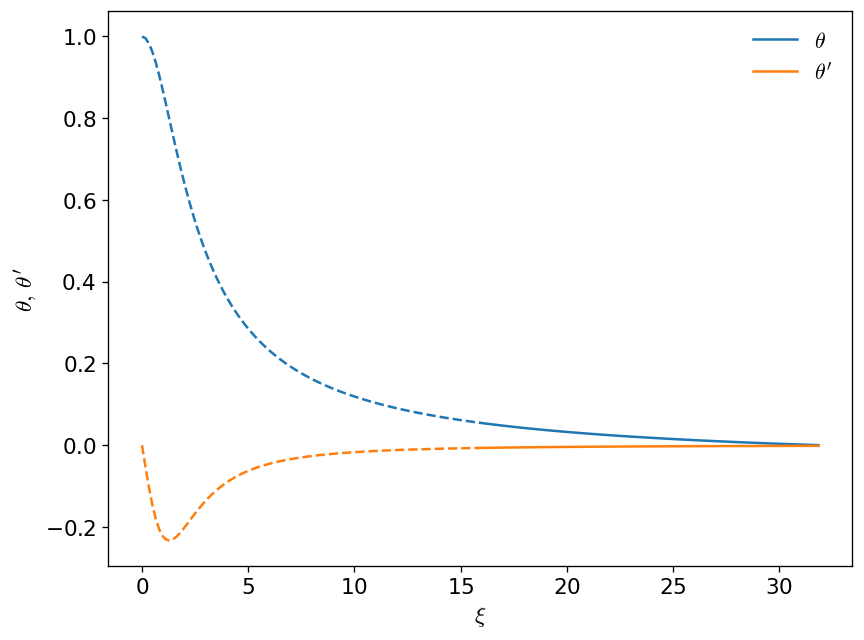

In [15]:
fig, ax = plt.subplots()

ax.plot(xi_in, y_in, color="C0", label=r"$\theta$")
ax.plot(xi_out, y_out, color="C0", ls="--")

ax.plot(xi_in, z_in, color="C1", label=r"$\theta'$")
ax.plot(xi_out, z_out, color="C1", ls="--")

ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel(r"$\theta,\, \theta'$", fontsize=14)

ax.legend(frameon=False, loc="best")